In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv("./web_sherlock/xg_samp_re_0.1_valid_result.csv")
df_valid = pd.read_csv("./we_data/validation.csv")

In [3]:
df.shape

(303925, 3)

In [4]:
df_valid.shape

(303925, 25)

In [5]:
df.head()

click  click_pred_per  click_pred_class
0      0        0.000199                 0
1      0        0.000127                 0
2      0        0.000127                 0
3      0        0.000140                 0
4      0        0.000111                 0

In [6]:
pCTR = df['click_pred_per'].as_matrix()

In [7]:
# parameters
# LOW = 10
# HIGH = 40
total_budget = 6250000
payprice = df_valid['payprice'].as_matrix()
Train_df = df_valid
avgCTR = 1793/2430981 #train set
#tuning...
# base_bid = 300

In [8]:
# c = 50
# lam = 0.000000052

In [9]:
# bidprices = base_bid*test_predictions/avgCTR

In [10]:
def generate_bidprice(c, lam, pCTR):
#     avgCTR = 1793/2430981#train set
    z = ((pCTR+((c**2)*(lam**2)+(pCTR**2))**(1/2))/(c*lam))**(1/3)
    bidprices = c*(z-1/z)
    assert bidprices.shape == pCTR.shape
    return bidprices

In [21]:
def generate_bidprice(c, lam, pCTR):
#     avgCTR = 1793/2430981#train set
    z = ((pCTR+((c**2)*(lam**2)+(pCTR**2))**(1/2))/(c*lam))**(1/3)
    bidprices = c*(z-1/z)
    for i in range(len(bidprices)):
        if np.log(pCTR[i])<-9:
            bidprices[i] = 0
    
    assert bidprices.shape == pCTR.shape
    return bidprices

In [11]:
def Prob3(Train_df,payprice,c, lam, pCTR):
    Train_Const_summ = pd.DataFrame({'Clicks':'', 'Spend':'', 'CTR':'', 'CPM':'', 'eCPC':''}, index=[0])
        
    current_budget = total_budget
#     win_times = 0
    Train_df['win'] = 0 #initialize win label
    bidprices = generate_bidprice(c, lam, pCTR)
    #start biding...
    for i in Train_df.index:
        if current_budget > 0:
            #generate bidprice:
            current_bidprice = bidprices[i]
            
#             if current_bidprice > current_budget:
#                 print('budget remains:',current_budget)
#                 break
#                 current_bidprice = current_budget
#             bidprices.append(current_bidprice)#record

            #Winning criterion:
            current_payprice = payprice[i]
            if current_bidprice > current_payprice:
                Train_df.at[i, 'win'] = int(1)
                current_budget = current_budget - current_payprice
#                 win_times = win_times + 1
            else:
                Train_df.at[i, 'win'] = int(0)
        else:
            print('lack of budget!',current_budget)
            break
    #biding end        
    
    Train_df_new = Train_df[Train_df['win']!=0]
    #wintimes,_ = Train_df_new.shape
    #print('wintimes:',wintimes)
    #print('current_budget',current_budget)

    Clk = Train_df_new['click'].sum()
    Imp = Train_df_new['click'].count()
    CTR = Clk/Imp
    Spd = total_budget - current_budget
    CPM = 1000*Spd/Imp
    eCPC = Spd/Clk
    
    Train_Const_summ.loc[0,'Clicks']=Clk
    Train_Const_summ.loc[0,'Spend']=Spd
    Train_Const_summ.loc[0,'CTR']=CTR
    Train_Const_summ.loc[0,'CPM']=CPM
    Train_Const_summ.loc[0,'eCPC']=eCPC

    print(Train_Const_summ)
    
    
    
    return Train_df,current_budget

In [12]:
# Train_df,current_budget = Prob3(Train_df,payprice,c, lam, pCTR)

In [13]:
# Train_Const_summ = pd.DataFrame({'Clicks':'', 'Spend':'', 'CTR':'', 'CPM':'', 'eCPC':''}, index=[0])
# Train_df_new = Train_df[Train_df['win']!=0]
# wintimes,_ = Train_df_new.shape
# print('wintimes:',wintimes)
# print('current_budget',current_budget)

# Clk = Train_df_new['click'].sum()
# Imp = Train_df_new['click'].count()
# CTR = Clk/Imp
# Spd = total_budget - current_budget
# CPM = 1000*Spd/Imp
# eCPC = Spd/Clk
    
# Train_Const_summ.loc[0,'Clicks']=Clk
# Train_Const_summ.loc[0,'Spend']=Spd
# Train_Const_summ.loc[0,'CTR']=CTR
# Train_Const_summ.loc[0,'CPM']=CPM
# Train_Const_summ.loc[0,'eCPC']=eCPC

# print(Train_Const_summ)

In [14]:
def calculate_click(Train_df,payprice,c, lam, pCTR):
    print('c:',c,';lambda:',lam)
    result_df,current_budget = Prob3(Train_df,payprice,c, lam, pCTR)
    print('current_budget:',current_budget)
    Train_df_new = result_df[result_df['win']!=0]
    wintimes,_ = Train_df_new.shape
    print('wintimes:',wintimes)
    print('----------------')
    Clk = Train_df_new['click'].sum()    
    return Clk

In [15]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import mpld3
import numpy as np

In [16]:
l, h = 2.881e-06, 3.266e-06
la = 3.081e-06
r = 0.0000001

In [22]:
cs = np.arange(50,150,10)
lams = np.arange(la-10*r,la+10*r,r)
maxClks=[]
for lam in lams:
    Clks = [calculate_click(Train_df,payprice,c, lam, pCTR) for c in cs]
    print('max@:',max(Clks))
    maxClks.append(max(Clks))
    
    fig = plt.figure()
    plt.plot(cs,Clks)
    mpld3.display(fig)
    
print('maxmax:',max(maxClks))

c: 50 ;lambda: 2.081e-06
       CPM         CTR Clicks    Spend     eCPC
0  41221.2  0.00111497    155  5730444  36970.6
current_budget: 519556
wintimes: 139017
----------------
c: 60 ;lambda: 2.081e-06
lack of budget! -6
       CPM         CTR Clicks    Spend     eCPC
0  43437.8  0.00108421    156  6250006  40064.1
current_budget: -6
wintimes: 143884
----------------
c: 70 ;lambda: 2.081e-06
lack of budget! -57
       CPM         CTR Clicks    Spend     eCPC
0  45319.8  0.00102966    142  6250057  44014.5
current_budget: -57
wintimes: 137910
----------------
c: 80 ;lambda: 2.081e-06
lack of budget! -119
       CPM         CTR Clicks    Spend     eCPC
0  46791.4  0.00104811    140  6250119  44643.7
current_budget: -119
wintimes: 133574
----------------
c: 90 ;lambda: 2.081e-06
lack of budget! -48
     CPM        CTR Clicks    Spend     eCPC
0  48023  0.0010296    134  6250048  46642.1
current_budget: -48
wintimes: 130147
----------------
c: 100 ;lambda: 2.081e-06
lack of budget! -15
  

lack of budget! -7
       CPM         CTR Clicks    Spend   eCPC
0  44147.5  0.00111605    158  6250007  39557
current_budget: -7
wintimes: 141571
----------------
c: 90 ;lambda: 2.481e-06
lack of budget! 0
       CPM         CTR Clicks    Spend   eCPC
0  45345.1  0.00106652    147  6250000  42517
current_budget: 0
wintimes: 137832
----------------
c: 100 ;lambda: 2.481e-06
lack of budget! -11
       CPM         CTR Clicks    Spend     eCPC
0  46326.2  0.00106735    144  6250011  43402.9
current_budget: -11
wintimes: 134913
----------------
c: 110 ;lambda: 2.481e-06
lack of budget! -11
       CPM        CTR Clicks    Spend     eCPC
0  47146.1  0.0010787    143  6250011  43706.4
current_budget: -11
wintimes: 132567
----------------
c: 120 ;lambda: 2.481e-06
lack of budget! -18
       CPM         CTR Clicks    Spend     eCPC
0  47859.5  0.00106439    139  6250018  44964.2
current_budget: -18
wintimes: 130591
----------------
c: 130 ;lambda: 2.481e-06
lack of budget! -24
       CPM       

lack of budget! -40
       CPM         CTR Clicks    Spend     eCPC
0  45396.4  0.00112582    155  6250040  40322.8
current_budget: -40
wintimes: 137677
----------------
c: 130 ;lambda: 2.881e-06
lack of budget! -34
       CPM         CTR Clicks    Spend   eCPC
0  46002.1  0.00108932    148  6250034  42230
current_budget: -34
wintimes: 135864
----------------
c: 140 ;lambda: 2.881e-06
lack of budget! -9
       CPM         CTR Clicks    Spend     eCPC
0  46465.7  0.00109287    147  6250009  42517.1
current_budget: -9
wintimes: 134508
----------------
max@: 166
c: 50 ;lambda: 2.981e-06
       CPM         CTR Clicks    Spend     eCPC
0  36776.4  0.00126162    146  4255915  29150.1
current_budget: 1994085
wintimes: 115724
----------------
c: 60 ;lambda: 2.981e-06
       CPM         CTR Clicks    Spend     eCPC
0  38753.4  0.00121559    149  4750160  31880.3
current_budget: 1499840
wintimes: 122574
----------------
c: 70 ;lambda: 2.981e-06
       CPM         CTR Clicks    Spend     eCPC
0  

       CPM         CTR Clicks    Spend     eCPC
0  38581.7  0.00124654    148  4580761  30951.1
current_budget: 1669239
wintimes: 118729
----------------
c: 80 ;lambda: 3.381e-06
       CPM         CTR Clicks    Spend     eCPC
0  39809.8  0.00125804    154  4873235  31644.4
current_budget: 1376765
wintimes: 122413
----------------
c: 90 ;lambda: 3.381e-06
       CPM         CTR Clicks    Spend     eCPC
0  40831.1  0.00126919    159  5115197  32171.1
current_budget: 1134803
wintimes: 125277
----------------
c: 100 ;lambda: 3.381e-06
       CPM       CTR Clicks    Spend   eCPC
0  41658.9  0.001263    161  5310432  32984
current_budget: 939568
wintimes: 127474
----------------
c: 110 ;lambda: 3.381e-06
       CPM         CTR Clicks    Spend     eCPC
0  42371.6  0.00126854    164  5477881  33401.7
current_budget: 772119
wintimes: 129282
----------------
c: 120 ;lambda: 3.381e-06
       CPM         CTR Clicks    Spend     eCPC
0  42964.8  0.00126193    165  5617740  34046.9
current_budget: 

       CPM         CTR Clicks    Spend     eCPC
0  41844.8  0.00130704    161  5154401  32014.9
current_budget: 1095599
wintimes: 123179
----------------
c: 140 ;lambda: 3.781e-06
       CPM         CTR Clicks    Spend     eCPC
0  42273.2  0.00131295    163  5248135  32197.1
current_budget: 1001865
wintimes: 124148
----------------
max@: 163
c: 50 ;lambda: 3.881e-06
       CPM         CTR Clicks    Spend     eCPC
0  33351.6  0.00140663    139  3295735  23710.3
current_budget: 2954265
wintimes: 98818
----------------
c: 60 ;lambda: 3.881e-06
       CPM         CTR Clicks    Spend     eCPC
0  35306.5  0.00136751    143  3692003  25818.2
current_budget: 2557997
wintimes: 104570
----------------
c: 70 ;lambda: 3.881e-06
     CPM         CTR Clicks    Spend     eCPC
0  36786  0.00132197    144  4007030  27826.6
current_budget: 2242970
wintimes: 108928
----------------
c: 80 ;lambda: 3.881e-06
       CPM         CTR Clicks    Spend     eCPC
0  37949.4  0.00132737    149  4259894  28589.9
cur

/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


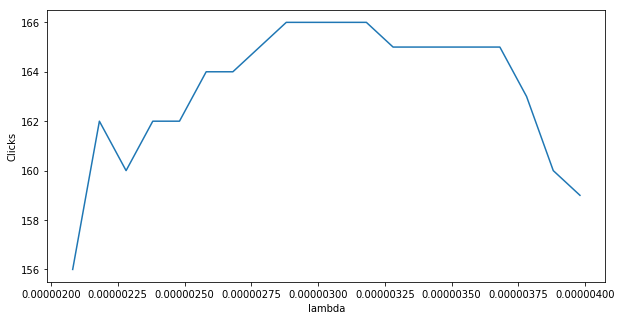

In [23]:
plt.figure(figsize = (10, 5))
plt.plot(lams,maxClks)
mpld3.display(fig)
# plt.xticks([-2, -1.8, -1, 1.22, 3],[r'$really\ bad$', r'$bad$', r'$normal$', r'$good$', r'$really\ good$'])

# plt.title('The Distribution of the Pearson Correlation Coefficients for the Four Class')
plt.xlabel('lambda')
plt.ylabel('Clicks')
plt.legend()

plt.show()

In [17]:
cs = np.arange(50,150,10)
lams = np.arange(la-10*r,la+10*r,r)
maxClks=[]
for lam in lams:
    Clks = [calculate_click(Train_df,payprice,c, lam, pCTR) for c in cs]
    print('max@:',max(Clks))
    maxClks.append(max(Clks))
    
    fig = plt.figure()
    plt.plot(cs,Clks)
    mpld3.display(fig)
    
print('maxmax:',max(maxClks))

c: 50 ;lambda: 2.081e-06
       CPM         CTR Clicks    Spend     eCPC
0  39804.2  0.00105047    155  5873230  37891.8
current_budget: 376770
wintimes: 147553
----------------
c: 60 ;lambda: 2.081e-06
lack of budget! -34
       CPM          CTR Clicks    Spend     eCPC
0  41959.8  0.000986888    147  6250034  42517.2
current_budget: -34
wintimes: 148953
----------------
c: 70 ;lambda: 2.081e-06
lack of budget! -75
       CPM          CTR Clicks    Spend     eCPC
0  43790.1  0.000987893    141  6250075  44326.8
current_budget: -75
wintimes: 142728
----------------
c: 80 ;lambda: 2.081e-06
lack of budget! -40
       CPM          CTR Clicks    Spend     eCPC
0  45225.6  0.000984102    136  6250040  45956.2
current_budget: -40
wintimes: 138197
----------------
c: 90 ;lambda: 2.081e-06
lack of budget! -8
       CPM          CTR Clicks    Spend     eCPC
0  46429.8  0.000980596    132  6250008  47348.5
current_budget: -8
wintimes: 134612
----------------
c: 100 ;lambda: 2.081e-06
lack of bu

lack of budget! -23
       CPM         CTR Clicks    Spend     eCPC
0  42700.5  0.00102481    150  6250023  41666.8
current_budget: -23
wintimes: 146369
----------------
c: 90 ;lambda: 2.481e-06
lack of budget! -12
       CPM        CTR Clicks    Spend     eCPC
0  43874.2  0.0010249    146  6250012  42808.3
current_budget: -12
wintimes: 142453
----------------
c: 100 ;lambda: 2.481e-06
lack of budget! -25
       CPM         CTR Clicks    Spend     eCPC
0  44825.9  0.00102561    143  6250025  43706.5
current_budget: -25
wintimes: 139429
----------------
c: 110 ;lambda: 2.481e-06
lack of budget! -177
       CPM         CTR Clicks    Spend     eCPC
0  45623.1  0.00102923    141  6250177  44327.5
current_budget: -177
wintimes: 136996
----------------
c: 120 ;lambda: 2.481e-06
lack of budget! -6
       CPM         CTR Clicks    Spend     eCPC
0  46315.2  0.00101523    137  6250006  45620.5
current_budget: -6
wintimes: 134945
----------------
c: 130 ;lambda: 2.481e-06
lack of budget! -30
   

lack of budget! -122
       CPM        CTR Clicks    Spend     eCPC
0  43998.2  0.0010489    149  6250122  41947.1
current_budget: -122
wintimes: 142054
----------------
c: 130 ;lambda: 2.881e-06
lack of budget! 0
       CPM         CTR Clicks    Spend     eCPC
0  44564.2  0.00104102    146  6250000  42808.2
current_budget: 0
wintimes: 140247
----------------
c: 140 ;lambda: 2.881e-06
lack of budget! -35
       CPM         CTR Clicks    Spend     eCPC
0  45041.1  0.00105936    147  6250035  42517.2
current_budget: -35
wintimes: 138763
----------------
max@: 166
c: 50 ;lambda: 2.981e-06
       CPM         CTR Clicks    Spend     eCPC
0  35607.5  0.00119676    146  4343972  29753.2
current_budget: 1906028
wintimes: 121996
----------------
c: 60 ;lambda: 2.981e-06
       CPM         CTR Clicks    Spend     eCPC
0  37532.3  0.00115509    149  4841441  32492.9
current_budget: 1408559
wintimes: 128994
----------------
c: 70 ;lambda: 2.981e-06
       CPM         CTR Clicks    Spend     eCPC
0

       CPM         CTR Clicks    Spend     eCPC
0  37464.2  0.00119211    148  4651183  31426.9
current_budget: 1598817
wintimes: 124150
----------------
c: 80 ;lambda: 3.381e-06
       CPM         CTR Clicks    Spend     eCPC
0  38662.9  0.00120405    154  4945057  32110.8
current_budget: 1304943
wintimes: 127902
----------------
c: 90 ;lambda: 3.381e-06
       CPM         CTR Clicks    Spend     eCPC
0  39660.8  0.00121555    159  5187830  32627.9
current_budget: 1062170
wintimes: 130805
----------------
c: 100 ;lambda: 3.381e-06
       CPM         CTR Clicks    Spend     eCPC
0  40470.5  0.00121032    161  5383501  33437.9
current_budget: 866499
wintimes: 133023
----------------
c: 110 ;lambda: 3.381e-06
       CPM         CTR Clicks    Spend   eCPC
0  41167.5  0.00121621    164  5551236  33849
current_budget: 698764
wintimes: 134845
----------------
c: 120 ;lambda: 3.381e-06
     CPM         CTR Clicks    Spend     eCPC
0  41747  0.00121029    165  5691417  34493.4
current_budget: 

       CPM         CTR Clicks    Spend     eCPC
0  40773.9  0.00126073    161  5206992  32341.6
current_budget: 1043008
wintimes: 127704
----------------
c: 140 ;lambda: 3.781e-06
       CPM         CTR Clicks    Spend     eCPC
0  41193.3  0.00126666    163  5300958  32521.2
current_budget: 949042
wintimes: 128685
----------------
max@: 163
c: 50 ;lambda: 3.881e-06
       CPM        CTR Clicks    Spend     eCPC
0  32469.3  0.0013519    139  3338428  24017.5
current_budget: 2911572
wintimes: 102818
----------------
c: 60 ;lambda: 3.881e-06
       CPM         CTR Clicks    Spend     eCPC
0  34385.3  0.00131596    143  3736514  26129.5
current_budget: 2513486
wintimes: 108666
----------------
c: 70 ;lambda: 3.881e-06
       CPM         CTR Clicks    Spend     eCPC
0  35836.5  0.00127331    144  4052785  28144.3
current_budget: 2197215
wintimes: 113091
----------------
c: 80 ;lambda: 3.881e-06
       CPM         CTR Clicks    Spend     eCPC
0  36977.7  0.00127937    149  4306567  28903.1
c

In [18]:
fig = plt.figure()
plt.plot(lams,maxClks)
mpld3.display(fig)

/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


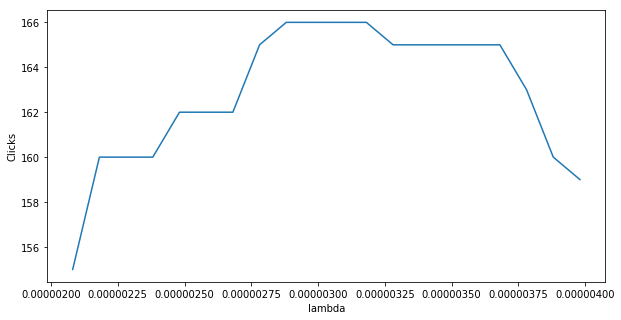

In [20]:
plt.figure(figsize = (10, 5))
plt.plot(lams,maxClks)
mpld3.display(fig)
# plt.xticks([-2, -1.8, -1, 1.22, 3],[r'$really\ bad$', r'$bad$', r'$normal$', r'$good$', r'$really\ good$'])

# plt.title('The Distribution of the Pearson Correlation Coefficients for the Four Class')
plt.xlabel('lambda')
plt.ylabel('Clicks')
plt.legend()

plt.show()

In [21]:
cs = np.arange(50,300,10)
lams = np.arange(l,h,r)
maxClks=[]
for lam in lams:
    Clks = [calculate_click(Train_df,payprice,c, lam, pCTR) for c in cs]
    print('max@:',max(Clks))
    maxClks.append(max(Clks))
    
    fig = plt.figure()
    plt.plot(cs,Clks)
    mpld3.display(fig)
    
print('maxmax:',max(maxClks))

c: 50 ;lambda: 2.881e-06
       CPM         CTR Clicks    Spend     eCPC
0  36000.5  0.00118124    147  4480079  30476.7
current_budget: 1769921
wintimes: 124445
----------------
c: 60 ;lambda: 2.881e-06
       CPM         CTR Clicks    Spend     eCPC
0  37937.9  0.00113977    150  4992814  33285.4
current_budget: 1257186
wintimes: 131605
----------------
c: 70 ;lambda: 2.881e-06
     CPM        CTR Clicks    Spend     eCPC
0  39459  0.0011689    160  5401181  33757.4
current_budget: 848819
wintimes: 136881
----------------
c: 80 ;lambda: 2.881e-06
     CPM         CTR Clicks    Spend     eCPC
0  40695  0.00114989    162  5733229  35390.3
current_budget: 516771
wintimes: 140883
----------------
c: 90 ;lambda: 2.881e-06
       CPM         CTR Clicks    Spend     eCPC
0  41725.7  0.00113808    164  6012759  36663.2
current_budget: 237241
wintimes: 144102
----------------
c: 100 ;lambda: 2.881e-06
lack of budget! -21
       CPM         CTR Clicks    Spend     eCPC
0  42636.6  0.00113243  

lack of budget! -4
       CPM         CTR Clicks    Spend     eCPC
0  47077.8  0.00107714    143  6250004  43706.3
current_budget: -4
wintimes: 132759
----------------
c: 240 ;lambda: 2.981e-06
lack of budget! -60
       CPM         CTR Clicks    Spend     eCPC
0  47224.4  0.00108048    143  6250060  43706.7
current_budget: -60
wintimes: 132348
----------------
c: 250 ;lambda: 2.981e-06
lack of budget! -66
       CPM         CTR Clicks    Spend     eCPC
0  47368.7  0.00108378    143  6250066  43706.8
current_budget: -66
wintimes: 131945
----------------
c: 260 ;lambda: 2.981e-06
lack of budget! -38
       CPM         CTR Clicks    Spend     eCPC
0  47481.9  0.00108638    143  6250038  43706.6
current_budget: -38
wintimes: 131630
----------------
c: 270 ;lambda: 2.981e-06
lack of budget! -54
       CPM       CTR Clicks    Spend     eCPC
0  47606.8  0.001074    141  6250054  44326.6
current_budget: -54
wintimes: 131285
----------------
c: 280 ;lambda: 2.981e-06
lack of budget! -8
       

lack of budget! -26
       CPM         CTR Clicks    Spend     eCPC
0  44641.8  0.00108568    152  6250026  41118.6
current_budget: -26
wintimes: 140004
----------------
c: 180 ;lambda: 3.181e-06
lack of budget! -25
       CPM         CTR Clicks    Spend     eCPC
0  44888.3  0.00107732    150  6250025  41666.8
current_budget: -25
wintimes: 139235
----------------
c: 190 ;lambda: 3.181e-06
lack of budget! -9
       CPM        CTR Clicks    Spend     eCPC
0  45180.2  0.0010771    149  6250009  41946.4
current_budget: -9
wintimes: 138335
----------------
c: 200 ;lambda: 3.181e-06
lack of budget! -84
       CPM       CTR Clicks    Spend     eCPC
0  45397.7  0.001075    148  6250084  42230.3
current_budget: -84
wintimes: 137674
----------------
c: 210 ;lambda: 3.181e-06
lack of budget! -59
       CPM         CTR Clicks    Spend     eCPC
0  45595.2  0.00107239    147  6250059  42517.4
current_budget: -59
wintimes: 137077
----------------
c: 220 ;lambda: 3.181e-06
lack of budget! -31
       C

In [22]:
fig = plt.figure()
plt.plot(lams,maxClks)
mpld3.display(fig)

In [17]:
lam = (l+h)/2
cs = np.arange(10,500,5)
Clks = [calculate_click(Train_df,payprice,c, lam, pCTR) for c in cs]
print('max@:',max(Clks))
fig = plt.figure()
plt.plot(cs,Clks)
mpld3.display(fig)

c: 10 ;lambda: 3.0735000000000003e-06
current_budget: 5417178
wintimes: 50502
----------------
c: 15 ;lambda: 3.0735000000000003e-06
current_budget: 4936658
wintimes: 66198
----------------
c: 20 ;lambda: 3.0735000000000003e-06
current_budget: 4472616
wintimes: 77661
----------------
c: 25 ;lambda: 3.0735000000000003e-06
current_budget: 3986154
wintimes: 87488
----------------
c: 30 ;lambda: 3.0735000000000003e-06
current_budget: 3495222
wintimes: 96361
----------------
c: 35 ;lambda: 3.0735000000000003e-06
current_budget: 3061360
wintimes: 103760
----------------
c: 40 ;lambda: 3.0735000000000003e-06
current_budget: 2677565
wintimes: 109963
----------------
c: 45 ;lambda: 3.0735000000000003e-06
current_budget: 2333038
wintimes: 115279
----------------
c: 50 ;lambda: 3.0735000000000003e-06
current_budget: 2030773
wintimes: 119784
----------------
c: 55 ;lambda: 3.0735000000000003e-06
current_budget: 1769894
wintimes: 123475
----------------
c: 60 ;lambda: 3.0735000000000003e-06
current

lack of budget! -9
current_budget: -9
wintimes: 130529
----------------
c: 395 ;lambda: 3.0735000000000003e-06
lack of budget! -14
current_budget: -14
wintimes: 130479
----------------
c: 400 ;lambda: 3.0735000000000003e-06
lack of budget! -33
current_budget: -33
wintimes: 130433
----------------
c: 405 ;lambda: 3.0735000000000003e-06
lack of budget! -43
current_budget: -43
wintimes: 130378
----------------
c: 410 ;lambda: 3.0735000000000003e-06
lack of budget! -76
current_budget: -76
wintimes: 130300
----------------
c: 415 ;lambda: 3.0735000000000003e-06
lack of budget! -50
current_budget: -50
wintimes: 130258
----------------
c: 420 ;lambda: 3.0735000000000003e-06
lack of budget! -58
current_budget: -58
wintimes: 130242
----------------
c: 425 ;lambda: 3.0735000000000003e-06
lack of budget! -54
current_budget: -54
wintimes: 130182
----------------
c: 430 ;lambda: 3.0735000000000003e-06
lack of budget! -163
current_budget: -163
wintimes: 130141
----------------
c: 435 ;lambda: 3.0735

In [26]:
cs = np.arange(100,300,10)
lams = np.arange(l-5*r,h,r)
maxClks=[]
for lam in lams:
    Clks = [calculate_click(Train_df,payprice,c, lam, pCTR) for c in cs]
    print('max@:',max(Clks))
    maxClks.append(max(Clks))
    
    fig = plt.figure()
    plt.plot(cs,Clks)
    mpld3.display(fig)
    
print('maxmax:',max(maxClks))

c: 10 ;lambda: 2.881e-06
current_budget: 5546353
wintimes: 43175
----------------
c: 20 ;lambda: 2.881e-06
current_budget: 4738531
wintimes: 65662
----------------
c: 30 ;lambda: 2.881e-06
current_budget: 3926135
wintimes: 81315
----------------
c: 40 ;lambda: 2.881e-06
current_budget: 3230836
wintimes: 92604
----------------
c: 50 ;lambda: 2.881e-06
current_budget: 2686761
wintimes: 100634
----------------
c: 60 ;lambda: 2.881e-06
current_budget: 2282338
wintimes: 106151
----------------
c: 70 ;lambda: 2.881e-06
current_budget: 1972912
wintimes: 110071
----------------
c: 80 ;lambda: 2.881e-06
current_budget: 1725225
wintimes: 113070
----------------
c: 90 ;lambda: 2.881e-06
current_budget: 1511914
wintimes: 115505
----------------
c: 100 ;lambda: 2.881e-06
current_budget: 1336728
wintimes: 117391
----------------
c: 110 ;lambda: 2.881e-06
current_budget: 1197701
wintimes: 118842
----------------
c: 120 ;lambda: 2.881e-06
current_budget: 1079026
wintimes: 120071
----------------
c: 13

current_budget: 1202736
wintimes: 117312
----------------
c: 140 ;lambda: 3.031e-06
current_budget: 1112839
wintimes: 118153
----------------
c: 150 ;lambda: 3.031e-06
current_budget: 1034733
wintimes: 118872
----------------
c: 160 ;lambda: 3.031e-06
current_budget: 968070
wintimes: 119462
----------------
c: 170 ;lambda: 3.031e-06
current_budget: 907890
wintimes: 120005
----------------
c: 180 ;lambda: 3.031e-06
current_budget: 854678
wintimes: 120465
----------------
c: 190 ;lambda: 3.031e-06
current_budget: 802554
wintimes: 120891
----------------
c: 200 ;lambda: 3.031e-06
current_budget: 756655
wintimes: 121288
----------------
c: 210 ;lambda: 3.031e-06
current_budget: 716843
wintimes: 121627
----------------
c: 220 ;lambda: 3.031e-06
current_budget: 679137
wintimes: 121928
----------------
c: 230 ;lambda: 3.031e-06
current_budget: 642950
wintimes: 122219
----------------
c: 240 ;lambda: 3.031e-06
current_budget: 613920
wintimes: 122450
----------------
c: 250 ;lambda: 3.031e-06
c

current_budget: 843643
wintimes: 118772
----------------
c: 260 ;lambda: 3.181e-06
current_budget: 820695
wintimes: 118959
----------------
c: 270 ;lambda: 3.181e-06
current_budget: 800071
wintimes: 119127
----------------
c: 280 ;lambda: 3.181e-06
current_budget: 781969
wintimes: 119267
----------------
c: 290 ;lambda: 3.181e-06
current_budget: 761427
wintimes: 119415
----------------
max@: 165
c: 10 ;lambda: 3.231e-06
current_budget: 5614917
wintimes: 40254
----------------
c: 20 ;lambda: 3.231e-06
current_budget: 4896477
wintimes: 61140
----------------
c: 30 ;lambda: 3.231e-06
current_budget: 4183395
wintimes: 75315
----------------
c: 40 ;lambda: 3.231e-06
current_budget: 3558708
wintimes: 85743
----------------
c: 50 ;lambda: 3.231e-06
current_budget: 3050604
wintimes: 93318
----------------
c: 60 ;lambda: 3.231e-06
current_budget: 2677699
wintimes: 98511
----------------
c: 70 ;lambda: 3.231e-06
current_budget: 2388964
wintimes: 102282
----------------
c: 80 ;lambda: 3.231e-06
c

In [27]:
fig = plt.figure()
plt.plot(lams,maxClks)
mpld3.display(fig)

In [17]:
lam = (l+h)/2
cs = np.arange(10,500,5)
Clks = [calculate_click(Train_df,payprice,c, lam, pCTR) for c in cs]
print('max@:',max(Clks))
fig = plt.figure()
plt.plot(cs,Clks)
mpld3.display(fig)

c: 10 ;lambda: 3.0735000000000003e-06
current_budget: 5417178
wintimes: 50502
----------------
c: 15 ;lambda: 3.0735000000000003e-06
current_budget: 4936658
wintimes: 66198
----------------
c: 20 ;lambda: 3.0735000000000003e-06
current_budget: 4472616
wintimes: 77661
----------------
c: 25 ;lambda: 3.0735000000000003e-06
current_budget: 3986154
wintimes: 87488
----------------
c: 30 ;lambda: 3.0735000000000003e-06
current_budget: 3495222
wintimes: 96361
----------------
c: 35 ;lambda: 3.0735000000000003e-06
current_budget: 3061360
wintimes: 103760
----------------
c: 40 ;lambda: 3.0735000000000003e-06
current_budget: 2677565
wintimes: 109963
----------------
c: 45 ;lambda: 3.0735000000000003e-06
current_budget: 2333038
wintimes: 115279
----------------
c: 50 ;lambda: 3.0735000000000003e-06
current_budget: 2030773
wintimes: 119784
----------------
c: 55 ;lambda: 3.0735000000000003e-06
current_budget: 1769894
wintimes: 123475
----------------
c: 60 ;lambda: 3.0735000000000003e-06
current

lack of budget! -9
current_budget: -9
wintimes: 130529
----------------
c: 395 ;lambda: 3.0735000000000003e-06
lack of budget! -14
current_budget: -14
wintimes: 130479
----------------
c: 400 ;lambda: 3.0735000000000003e-06
lack of budget! -33
current_budget: -33
wintimes: 130433
----------------
c: 405 ;lambda: 3.0735000000000003e-06
lack of budget! -43
current_budget: -43
wintimes: 130378
----------------
c: 410 ;lambda: 3.0735000000000003e-06
lack of budget! -76
current_budget: -76
wintimes: 130300
----------------
c: 415 ;lambda: 3.0735000000000003e-06
lack of budget! -50
current_budget: -50
wintimes: 130258
----------------
c: 420 ;lambda: 3.0735000000000003e-06
lack of budget! -58
current_budget: -58
wintimes: 130242
----------------
c: 425 ;lambda: 3.0735000000000003e-06
lack of budget! -54
current_budget: -54
wintimes: 130182
----------------
c: 430 ;lambda: 3.0735000000000003e-06
lack of budget! -163
current_budget: -163
wintimes: 130141
----------------
c: 435 ;lambda: 3.0735

In [19]:
lam = (l+h)/2
cs = np.arange(50,150,5)
Clks = [calculate_click(Train_df,payprice,c, lam, pCTR) for c in cs]
print('max@:',max(Clks))
fig = plt.figure()
plt.plot(cs,Clks)
mpld3.display(fig)

c: 50 ;lambda: 3.0735000000000003e-06
current_budget: 2030773
wintimes: 119784
----------------
c: 55 ;lambda: 3.0735000000000003e-06
current_budget: 1769894
wintimes: 123475
----------------
c: 60 ;lambda: 3.0735000000000003e-06
current_budget: 1544659
wintimes: 126644
----------------
c: 65 ;lambda: 3.0735000000000003e-06
current_budget: 1342032
wintimes: 129362
----------------
c: 70 ;lambda: 3.0735000000000003e-06
current_budget: 1155191
wintimes: 131751
----------------
c: 75 ;lambda: 3.0735000000000003e-06
current_budget: 989599
wintimes: 133860
----------------
c: 80 ;lambda: 3.0735000000000003e-06
current_budget: 843382
wintimes: 135628
----------------
c: 85 ;lambda: 3.0735000000000003e-06
current_budget: 705789
wintimes: 137248
----------------
c: 90 ;lambda: 3.0735000000000003e-06
current_budget: 582260
wintimes: 138661
----------------
c: 95 ;lambda: 3.0735000000000003e-06
current_budget: 468232
wintimes: 139967
----------------
c: 100 ;lambda: 3.0735000000000003e-06
curren

In [20]:
lam = (l+h)/2
cs = np.arange(100,121,1)
Clks = [calculate_click(Train_df,payprice,c, lam, pCTR) for c in cs]
print('max@:',max(Clks))
fig = plt.figure()
plt.plot(cs,Clks)
mpld3.display(fig)

c: 100 ;lambda: 3.0735000000000003e-06
current_budget: 358138
wintimes: 141161
----------------
c: 101 ;lambda: 3.0735000000000003e-06
current_budget: 337707
wintimes: 141384
----------------
c: 102 ;lambda: 3.0735000000000003e-06
current_budget: 317255
wintimes: 141602
----------------
c: 103 ;lambda: 3.0735000000000003e-06
current_budget: 299676
wintimes: 141795
----------------
c: 104 ;lambda: 3.0735000000000003e-06
current_budget: 278371
wintimes: 142023
----------------
c: 105 ;lambda: 3.0735000000000003e-06
current_budget: 259533
wintimes: 142227
----------------
c: 106 ;lambda: 3.0735000000000003e-06
current_budget: 238875
wintimes: 142436
----------------
c: 107 ;lambda: 3.0735000000000003e-06
current_budget: 220214
wintimes: 142648
----------------
c: 108 ;lambda: 3.0735000000000003e-06
current_budget: 202464
wintimes: 142837
----------------
c: 109 ;lambda: 3.0735000000000003e-06
current_budget: 184839
wintimes: 143020
----------------
c: 110 ;lambda: 3.0735000000000003e-06
c

In [22]:
#result
lam = (l+h)/2
c = 110
print(lam)
print(c)

3.0735000000000003e-06
110


In [17]:
cs = np.arange(10,500,5)
lams = np.arange(l,h,0.00000005), 
maxClks=[]
for lam in lams:
    Clks = [calculate_click(Train_df,payprice,c, lam, pCTR) for c in cs]
    print('max@:',max(Clks))
    maxClks.append(max(Clks))
    
    fig = plt.figure()
    plt.plot(cs,Clks)
    mpld3.display(fig)
    
print('maxmax:',max(maxClks))

c: 10 ;lambda: [2.881e-06 2.931e-06 2.981e-06 3.031e-06 3.081e-06 3.131e-06 3.181e-06
 3.231e-06]


ValueError: operands could not be broadcast together with shapes (8,) (303925,) 

In [ ]:
#thisisend

In [66]:
# parameters
# LOW = 10
# HIGH = 40
total_budget = 6250000
payprice = df_valid['payprice'].as_matrix()
Train_df = df_valid
avgCTR = 1793/2430981 #train set
#tuning...
base_bid = 68

In [67]:
Train_df,current_budget = Prob3(Train_df,payprice,base_bid,test_predictions)

In [68]:
Train_Const_summ = pd.DataFrame({'Clicks':'', 'Spend':'', 'CTR':'', 'CPM':'', 'eCPC':''}, index=[0])
Train_df_new = Train_df[Train_df['win']!=0]
wintimes,_ = Train_df_new.shape
print('wintimes:',wintimes)
print('current_budget',current_budget)

Clk = Train_df_new['click'].sum()
Imp = Train_df_new['click'].count()
CTR = Clk/Imp
Spd = total_budget - current_budget
CPM = 1000*Spd/Imp
eCPC = Spd/Clk
    
Train_Const_summ.loc[0,'Clicks']=Clk
Train_Const_summ.loc[0,'Spend']=Spd
Train_Const_summ.loc[0,'CTR']=CTR
Train_Const_summ.loc[0,'CPM']=CPM
Train_Const_summ.loc[0,'eCPC']=eCPC

print(Train_Const_summ)

wintimes: 120965
current_budget 253018
       CPM          CTR Clicks    Spend     eCPC
0  49576.2  0.000810152     98  5996982  61193.7


In [9]:
# #字典中的key值即为csv中列名
# dataframe = pd.DataFrame({'bidprice':bidprices})

# #将DataFrame存储为csv,index表示是否显示行名，default=True
# dataframe.to_csv("bidprice10-40.csv",index=False,sep=',')

In [ ]:
# group_df = pd.read_csv('/Users/qrdai/web_project/we_data/train.csv')